# Lesson 7 - Parkinson PCR

## Author - Aeden Jameson

### Description:

Perform Principal Component Regression on a <a href="https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring">dataset that tracked patients with Parkinson's Disease</a>.

Citation: A Tsanas, MA Little, PE McSharry, LO Ramig (2009)
'Accurate telemonitoring of Parkinson's disease progression by non-invasive speech tests',
IEEE Transactions on Biomedical Engineering.

About the data:
This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes.

#### Instructions:

 1. Load the dataset.
 2. Create the X-matrix (one-hot encoding categorical factors).
 3. Scale the X-matrix.
 4. Create the principal components and do a simple plot of the explained variance.
 5. SVD- Linear regression with the singular value decomposition.

Report on:

 1. Number of components before and after (choose a smaller number of principal components and explain how you chose them).
 2. Interpret the adjusted R-squared.

In [1]:
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import scipy.stats as ss

# Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

def set_D(s, cutoff=0.01):
    '''Function creates inverse singular value matrix for 
    singular values greater than cutoff * largest singular value.'''
    d = []
    for sv in s:
        if(sv > cutoff * s[0]): d.append(1.0/sv)
        else: d.append(0.0)
    return np.diag(d)

def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()

def residual_plot(df):
    RMSE = np.std(df.resids)
    sns.scatterplot(x='predicted', y='resids', data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('PLot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()  


### Step 1: Load the dataset.

In [3]:
parkinsons_df = pd.read_csv(filename)
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
parkinsons_df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

### Step 2 & 3: Scale the X-matrix

In [5]:
# Define the target and features:
target_label = 'total_UPDRS'
non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in parkinsons_df.columns if x not in [target_label] + non_features]


# Filter out non-features and non-targets
parkinsons_df = parkinsons_df.drop(non_features, axis=1)

# Get target and original x-matrix
y = parkinsons_df[target_label]
X = parkinsons_df.as_matrix(columns=feature_labels)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [6]:
# Scale all columns first
x_scaled = np.apply_along_axis(scale, 1, X)
y_scaled = np.apply_along_axis(scale, 0, y)

### Step 4: Create the principal components and do a simple plot of the explained variance.

It's unclear from this conversation, https://canvas.uw.edu/courses/1347202/discussion_topics/5101799, whether we should be doing this part or not, but here it is.

In [7]:
# PCR!!
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
pca_result = pca.fit_transform(x_scaled)

column_names = ['pc' + str(ix+1) for ix in range(x_scaled.shape[1])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target_label] = y_scaled

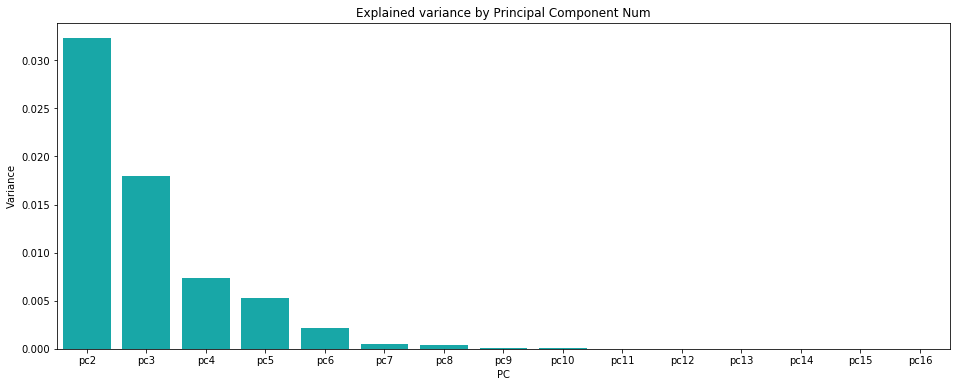

In [8]:
pc_df = pd.DataFrame({'Variance':pca.explained_variance_ratio_,
             'PC':column_names})
plt.figure(figsize=(16, 6))

ax = sns.barplot(x='PC',y="Variance",  data=pc_df[1:], color="c")
ax.set_title("Explained variance by Principal Component Num");

Because the first value is so large we graph everything after the first. Looks like we are probably interested in 5-7 features that would entail most of the variance.

### Step 5: SVD- Linear regression with the singular value decomposition.


#### Create Model


The singular values from the SVD are 
[3.06264385e+02 1.38525105e+01 2.32847374e+00 1.39087156e+00
 1.23321111e+00 1.05786433e+00 3.20622795e-01 2.98369389e-01
 1.69879064e-01 1.04095435e-01 7.05846930e-02 3.48043085e-02
 1.85596294e-02 2.98655095e-04 4.40741423e-05 4.54703863e-14]:


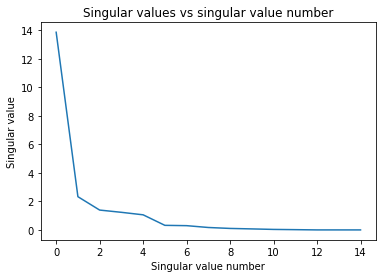

In [9]:
U, s, V = np.linalg.svd(x_scaled, full_matrices=False)
plt.plot(s[1:])
plt.title('Singular values vs singular value number')
plt.ylabel('Singular value')
plt.xlabel('Singular value number')

print('\nThe singular values from the SVD are \n{}:'.format(s))



We omit the first value in plot in order to get a better look at the values. By examining the array of singular values we see that we're interested in the first six values. The rest are pretty close to zero.

In [10]:
# set singular values below .01 to 0 for the calculation of the diag matrix
D = set_D(s, .002)
np.round(D,3)

MP_inverse = np.dot(V, np.dot(D, np.transpose(U)))

# Calculate the coeffients of our linear regression problem
b = np.dot(MP_inverse, y)

#### Predict Total UDPRS

In [11]:
data = {'total_UDPRS': y, 'predicted': scale(np.dot(X, b)) }
predictions = pd.DataFrame(data, columns = ['total_UDPRS', 'predicted'])
total_udprs_scale = np.std(y[1:])
total_udprs_mean = np.mean(y[1:])
print('The mean actual of total udprs = {}   STD = {}\n'.format(total_udprs_mean, total_udprs_scale))
predictions.loc[:,'predicted'] = np.multiply(total_udprs_scale, predictions.loc[:,'predicted'])
predictions.loc[:,'predicted'] = np.add(total_udprs_mean,  predictions.loc[:,'predicted'])
predictions.head()

The mean actual of total udprs = 29.01802654068777   STD = 10.700053038262933



,total_UDPRS,predicted
0,34.398,29.320952
1,34.894,42.949123
2,35.389,32.213431
3,35.810,34.852970
4,36.375,39.780977


### Results Summary

Mean of predicted values = 29.018026540687774
STD of predicted values = 10.700053038262933



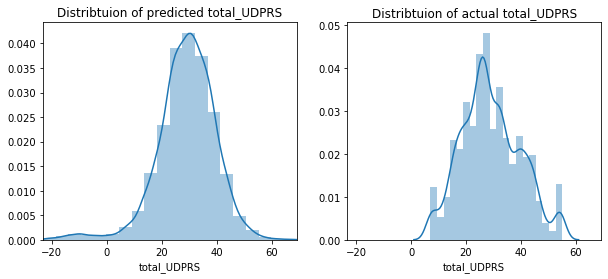

In [12]:
xmin = min(min(predictions.predicted), min(predictions.total_UDPRS))
xmax = max(max(predictions.predicted), max(predictions.total_UDPRS))
print('Mean of predicted values = {}'.format(np.mean(predictions.predicted)))
print('STD of predicted values = {}\n'.format(np.std(predictions.predicted)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.distplot(predictions.predicted, bins=20, ax=ax[0])
ax[0].set_title('Distribtuion of predicted total_UDPRS')
ax[0].set_xlabel('total_UDPRS')
ax[0].set_xlim(xmin,xmax)
sns.distplot(predictions.total_UDPRS, bins=20, ax=ax[1])
ax[1].set_title('Distribtuion of actual total_UDPRS')
ax[1].set_xlabel('total_UDPRS')
_=ax[1].set_xlim(xmin,xmax)

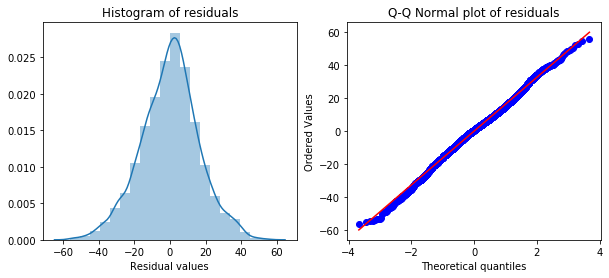

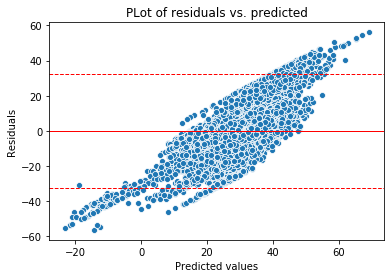

In [13]:
predictions.loc[:,'resids'] = np.subtract(predictions.loc[:,'predicted'],predictions.loc[:,'total_UDPRS'])
plot_resid_dist(predictions.loc[:,'resids'])
residual_plot(predictions)

While the residuals are approximately normally distributed, they are strongly heteroscedastic. The residuals trend strongly with predicted value, indicating the model is just predicting regression to the mean.  

In [14]:
SSR = np.sum(np.square(predictions.loc[:,'resids']))
SST = np.sum(np.square(predictions.loc[:,'total_UDPRS'] - total_udprs_mean))

print('SSR: {}'.format(SSR))
print('SST: {}'.format(SST))

R2 = 1.0 - (SSR / SST)

print('R-squared = {}'.format(R2))

SSR: 1562921.8760338605
SST: 672549.8712315352
R-squared = -1.3238750654608356


These metrics indicate that the model explains nothing. We would be better off just using the mean of total_UDPRS as the prediction. This approach would at least give an $R^2$ value of 0. 